In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import re
import glob, random
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import to_categorical

# Handling media files
some function definitions to get/write frames from video or folder
(not all of the functions are called in the rest of the code)

In [ ]:
##read frames from a video and load them into col_images2
def vid2photos(vid_path):
  myFrameNumber = 50
  cap = cv2.VideoCapture(vid_path)
  # '/content/drive/My Drive/lane_detection/videoplayback.mp4'
  # get total number of frames
  totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

  # check for valid frame number
  if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
      # set frame position
      cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber)
  col_images2=[]
  while True:
      ret, frame = cap.read()
      # print(ret)
      if (ret):
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (128, 128))
        col_images2.append(frame)
        # plt.figure(figsize=(10,10))
        # plt.imshow(frame[:,:,0], cmap= "gray")
        # plt.show()
      else:
        break
      if cv2.waitKey(20) & 0xFF == ord('q'):
          break
  cv2.destroyAllWindows()
  return col_images2

In [ ]:
def photos2vid(pathIn, pathOut):
  # input frames path
  # pathIn= '/content/drive/My Drive/lane_detection/detected_test_averageing_resized_blank/'

  # output path to save the video
  # pathOut = '/content/drive/My Drive/lane_detection/roads_test_averaging_resized_blank.mp4'

  # specify frames per second
  fps = 30.0


  from os.path import isfile, join

  # get file names of the frames
  files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
  files.sort(key=lambda f: int(re.sub('\D', '', f)))

  frame_list = []

  for i in tqdm_notebook(range(len(files))):
      filename=pathIn + files[i]
      #reading each files
      img = cv2.imread(filename)
      height, width, layers = img.shape
      size = (width,height)
      
      #inserting the frames into an image array
      frame_list.append(img)

  plt.figure(figsize=(10,10))
  plt.imshow(frame_list[0], cmap= "gray")
  plt.show()    
  # write the video
  out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

  for i in range(len(frame_list)):
      # writing to a image array
      out.write(frame_list[i])

  out.release()
  return True

In [ ]:
#sampling images
#not used anywhere
def readFrameFolder(path, bin=False):
  col_frames = os.listdir(path)
  col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

  # load frames
  X=[]
  for i in tqdm_notebook(col_frames):
      img = cv2.imread(path+''+i)
      if bin:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      X.append(img)
      return X

In [ ]:
def frames2folder(frames, path):
  for i in tqdm_notebook(frames):
    img=frames[i]
    cv2.imwrite(path+str(i)+'.png',img)

# Model
U-net architecture functional model, 3 layers deep:
3conv and downsampling layers and 3conv and upscaling layers
concatention layers produce the input from 


In [ ]:
InLayer = keras.Input(shape=(128, 128, 3 ))
conv1 = Conv2D(16, kernel_size=3,padding="same", data_format = "channels_last",activation='relu')(InLayer)
max1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, kernel_size=3,padding="same", activation='relu' )(max1)
max2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, kernel_size=3,padding="same", activation='relu' )(max2)


conv4 = Conv2D(64, kernel_size=3,padding="same", activation='relu' )(conv3)
up1 = UpSampling2D( size=(2, 2),  interpolation="nearest")(conv4)
conc1 = Concatenate()([up1, conv2])
conv5 = Conv2D(32, kernel_size=3,padding="same", activation='relu' )(conc1)
up2 = UpSampling2D( size=(2, 2),  interpolation="nearest")(conv5)
conc2 = Concatenate()([up2, conv1])
conv6 = Conv2D(16, kernel_size=3,padding="same", activation='relu')(conc2)
# Conv2D(1, kernel_size=3,padding="same", activation='relu')

OutLayer = Conv2D(1, kernel_size=3,padding="same", activation='sigmoid')(conv6)

fmodel = Model(inputs=InLayer, outputs=OutLayer)
fmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 32)   4640        max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [ ]:
fmodel.compile(loss = "categorical_crossentropy",  
   optimizer = 'rmsprop', metrics = ['accuracy'])

##Get training data
training data is read from folder and normalised to get all pixel colour values between 0 and 1 instead of 0 and 255 to apply sigmoid function to classify the pixels into within lane or outside lane.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


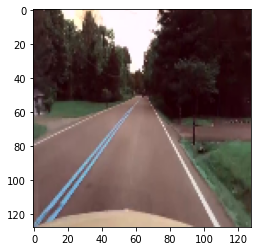

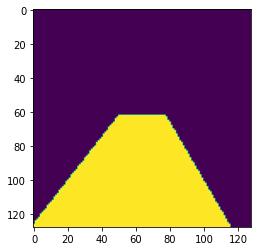

337


In [ ]:
# X= readFrameFolder('/content/drive/My Drive/lane_detection/input_sampled/')
# y= readFrameFolder('/content/drive/My Drive/lane_detection/output_sampled/', bin=True)

col_frames = os.listdir('/content/drive/My Drive/lane_detection/input_sampled/')
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

  # load frames
X=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread('/content/drive/My Drive/lane_detection/input_sampled/'+''+i)
    X.append(img)
col_frames = os.listdir('/content/drive/My Drive/lane_detection/output_sampled/')
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

  # load frames
y=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread('/content/drive/My Drive/lane_detection/output_sampled/'+''+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    y.append(img)


plt.imshow(X[0])
plt.show()
plt.imshow(y[0])
plt.show()
print(len(X))

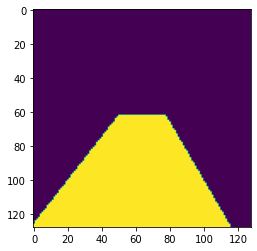

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
x_train=np.array(X)
y_train=np.array(y)

#normalising the data
x_train=x_train/255
y_train=y_train/255


print(y_train.shape)
plt.imshow(y_train[0])
plt.show()


In [ ]:
fmodel.fit(x_train, y_train, epochs=200, validation_split=0.2)

Epoch 1/200
9/9 [==============================] - 27s 3s/step - loss: 176.6396 - accuracy: 0.4603 - val_loss: 168.4208 - val_accuracy: 0.5139
Epoch 2/200
9/9 [==============================] - 26s 3s/step - loss: 175.2609 - accuracy: 0.5595 - val_loss: 166.7355 - val_accuracy: 0.7952
Epoch 3/200
9/9 [==============================] - 27s 3s/step - loss: 170.7874 - accuracy: 0.8228 - val_loss: 162.4824 - val_accuracy: 0.8508
Epoch 4/200
9/9 [==============================] - 26s 3s/step - loss: 168.2727 - accuracy: 0.8173 - val_loss: 158.5537 - val_accuracy: 0.8469
Epoch 5/200
9/9 [==============================] - 26s 3s/step - loss: 164.1057 - accuracy: 0.8284 - val_loss: 158.1127 - val_accuracy: 0.9181
Epoch 6/200
9/9 [==============================] - 26s 3s/step - loss: 164.0604 - accuracy: 0.8613 - val_loss: 156.9753 - val_accuracy: 0.9521
Epoch 7/200
9/9 [==============================] - 26s 3s/step - loss: 165.8450 - accuracy: 0.8352 - val_loss: 157.0587 - val_accuracy: 0.8682

In [ ]:
fmodel.save('/content/drive/My Drive/lane_detection/trained_model3_200_fixed.h5/')

INFO:tensorflow:Assets written to: /content/drive/My Drive/lane_detection/trained_model3_200_fixed.h5/assets


In [ ]:
fmodel = load_model('/content/drive/My Drive/lane_detection/trained_model3_200_fixed.h5')

#Testing the model

In [ ]:
# initial evaluation using the training dataset:

score = fmodel.evaluate(test_data, res_data, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 164.99606323242188
Test accuracy: 0.9814453125


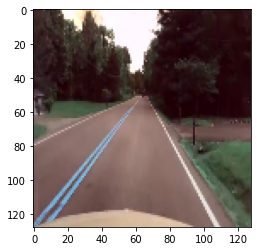

In [ ]:
#read video for testing
test_frames = vid2photos('/content/drive/My Drive/lane_detection/videoplayback.mp4')
#normalise frames to have similar value range to model training input
test_frames=np.array(test_frames)/255
plt.imshow(test_frames[0])

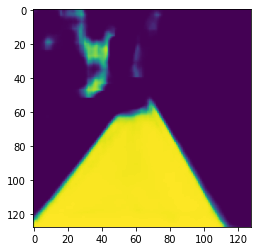

In [ ]:

pred_vid=fmodel.predict(np.array(test_frames))
#stretch colour value range to 0 to 255 again to match the expected image format for saving
pred_video=np.round(np.array(pred_vid)*255)
plt.imshow(pred_video[50][:,:,0])
plt.show()

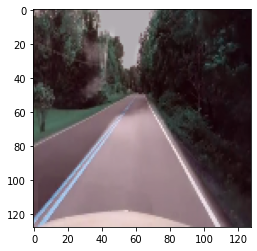

In [ ]:
plt.imshow(test_frames[50])
plt.imshow(pred_video[50][:,:,0], cmap='gray',alpha=0.3)
plt.show()

In [ ]:
j=0
for img in tqdm_notebook(pred_video):
  # print(i)
  cv2.imwrite('/content/drive/My Drive/lane_detection/ML3_200_fixed/'+str(j)+'.png',img[:,:,0])
  j+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


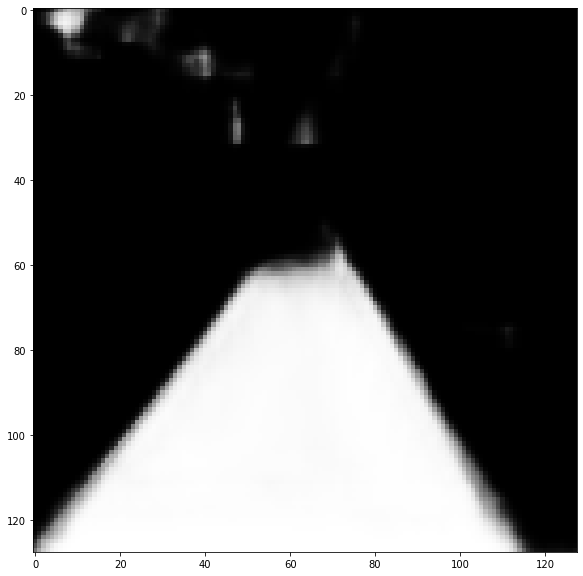

True

In [ ]:
photos2vid('/content/drive/My Drive/lane_detection/ML3_200_fixed/','/content/drive/My Drive/lane_detection/videoML_3_500_2.mp4')